# Analysis - Combined Experiments

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
import scipy.stats as ss

def swap_ioi_bpm(t):
    """
    Converts an interonset interval (IOI) in milliseconds to tempo in beats per minute, or
    BPM to the corresponding IOI. Conveniently, the equation is the same to convert in either
    direction - just divide 60000 ms by your value. Sometimes the universe is benign. :)
    :param t: Either an interonset interval in milliseconds or a BPM value. Can also be an array
        of these values.
    :return: If t was an interonset interval, result will be the corresponding BPM.
        If t was a tempo in BPM, result will be the corresponding interonset interval.
    """
    return 60000 / t

# Define constants
FIGURE_PATH = './figures/'
IOI_LEVELS = np.array([1000, 918, 843, 774, 710, 652, 599, 550, 504, 463, 425, 390, 358, 329, 302])
IOI_BINS = [(IOI_LEVELS[3*i], IOI_LEVELS[1+3*i], IOI_LEVELS[2+3*i]) for i in range(5)]
TEMPO_LEVELS = swap_ioi_bpm(IOI_LEVELS)
TEMPO_BINS = [(TEMPO_LEVELS[3*i], TEMPO_LEVELS[1+3*i], TEMPO_LEVELS[2+3*i]) for i in range(5)]
PITCH_LEVELS = [2, 3, 4, 5, 6, 7]
LOUDNESS_LEVELS = [0, 1, 2]
METRONOME_IOI = 550
METRONOME_TEMPO = swap_ioi_bpm(550)

# Define functions to convert between tempos and ratings
def bpm_to_rating(bpm, referent=METRONOME_TEMPO, intercept=50, slope=50):
    """
    Calculates location of any tempo in BPM on the scale used in the study. Appears
    in the manuscript as Equation 1.

    The default intercept and slope are the ground truth values, and assume 1) that a
    score of 50 corresponds to a tempo equal to the metronome and 2) every doubling of
    the tempo increases the score by 50. Subject-specific slopes and intercepts can be
    passed as arguments instead to obtain r_hat (see Equation 3).
    """
    return intercept + slope * np.log2(bpm / referent)

def rating_to_bpm(r, referent=METRONOME_TEMPO, intercept=50, slope=50):
    """
    Converts any relative tempo rating to its corresponding tempo in BPM.
    Appears in the manuscript as Equation 2.

    The default intercept and slope used in the equation are the ground truth values,
    but subject-specific slopes and intercepts can be passed as arguments instead to
    obtain t_hat (see Equation 4).
    """
    return referent * 2 ** ((r - intercept) / slope)

# Calculate "correct" ratings for each IOI and tempo range
CORRECT_RATINGS = [rating_to_bpm(tempo) for tempo in TEMPO_LEVELS]

# Adjust matplotlib settings
plt.rc('figure', titlesize=32)  # fontsize of the figure title
plt.rc('axes', labelsize=28)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=23)    # fontsize of the tick labels
plt.rc('ytick', labelsize=23)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

## Load Experiment 1

In [2]:
# Set file paths
DATAFILE = '../../E1/data/response_data.csv'
EXCFILE = '../../E1/data/excluded.txt'

# Load data
data0 = pd.read_csv(DATAFILE)

# Remove excluded participants
excluded = np.loadtxt(EXCFILE, dtype=int)
data0 = data0[~np.isin(data0.subject, excluded)]

## Load Experiment 2

In [3]:
# Set file paths
DATAFILE = '../../E2/data/response_data.csv'
EXCFILE = '../../E2/data/excluded.txt'

# Load data
data1 = pd.read_csv(DATAFILE)

# Remove excluded participants
excluded = np.loadtxt(EXCFILE, dtype=int)
data1 = data1[~np.isin(data1.subject, excluded)]

# Add 1000 to the ID numbers from E2 so they do not overlap
data1.loc[:, 'subject'] += 1000

## Load Experiment 3

In [4]:
# Set file paths
DATAFILE = '../data/response_data.csv'
EXCFILE = '../data/excluded.txt'

# Load data
data2 = pd.read_csv(DATAFILE)

# Remove excluded participants
excluded = np.loadtxt(EXCFILE, dtype=int)
data2 = data2[~np.isin(data2.subject, excluded)]

# Add 2000 to the ID numbers from E3 so they do not overlap
data2.loc[:, 'subject'] += 2000

## Combine data frames

In [5]:
data = pd.concat((data0, data1, data2), axis=0, join="outer", ignore_index=True)
outliers = data.cooks > 4 / 90
data = data[~outliers]
print('Percent outlier data: ', np.mean(outliers) * 100)

Percent outlier data:  5.365572826712723


# Raw Tempo Ratings

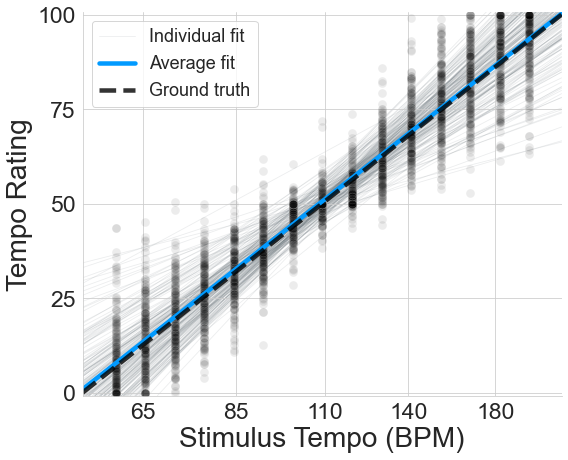

In [6]:
# Get subject averages
subj_avg = data.groupby(['subject', 'tempo']).response.mean().reset_index()
subj_slopes = data.groupby('subject').slope.mean().reset_index()
subj_intercepts = data.groupby('subject').intercept.mean().reset_index()

plt.figure()

# Scatterplot
ax = sns.scatterplot(x=np.log2(subj_avg.tempo), y='response', data=subj_avg, alpha=.075, color='k', s=75, zorder=1)

# Individual subject fits
for i in range(len(subj_slopes)):
    slope = subj_slopes.iloc[i, 1]
    intercept = subj_intercepts.iloc[i, 1]
    plt.axline((np.log2(TEMPO_LEVELS[0]), bpm_to_rating(TEMPO_LEVELS[0], intercept=intercept, slope=slope)),
               (np.log2(TEMPO_LEVELS[-1]), bpm_to_rating(TEMPO_LEVELS[-1], intercept=intercept, slope=slope)),
               c='#5E6A71', ls='-', alpha=.12, zorder=0, lw=.8, label='Individual fit' if i==0 else None)
        
# Average of all subject fits
inter = subj_intercepts.intercept.mean()
slope = subj_slopes.slope.mean()
plt.axline((np.log2(TEMPO_LEVELS[0]), bpm_to_rating(TEMPO_LEVELS[0], intercept=inter, slope=slope)),
           (np.log2(TEMPO_LEVELS[-1]), bpm_to_rating(TEMPO_LEVELS[-1], intercept=inter, slope=slope)),
           c='#019AFF', ls='-', alpha=1, label='Average fit', lw=4.5, zorder=2)

# Ground truth line
plt.axline((np.log2(TEMPO_LEVELS[0]), bpm_to_rating(TEMPO_LEVELS[0], intercept=50, slope=50)),
           (np.log2(TEMPO_LEVELS[-1]), bpm_to_rating(TEMPO_LEVELS[-1], intercept=50, slope=50)),
           c='k', ls='--', alpha=.8, label='Ground truth', lw=4.5, zorder=2)

plt.xlabel('Stimulus Tempo (BPM)')
plt.ylabel('Tempo Rating')
plt.yticks(range(0, 101, 25))
#plt.xticks(np.log(1/np.array(IOI_LEVELS)))
#ax.set_xticklabels(np.array(IOI_LEVELS), rotation=45)
plt.xticks(np.log2([65, 85, 110, 140, 180]))
ax.set_xticklabels([65, 85, 110, 140, 180], rotation=0)
plt.xlim(np.log2(swap_ioi_bpm(1100)), np.log2(swap_ioi_bpm(275)))
plt.ylim(-.8, 100.8)
plt.legend()

plt.gcf().set_size_inches(8, 6.5)
plt.tight_layout()

plt.gcf().savefig(FIGURE_PATH + 'raw_ratings_combined.svg')

# Illusory Tempo Effect

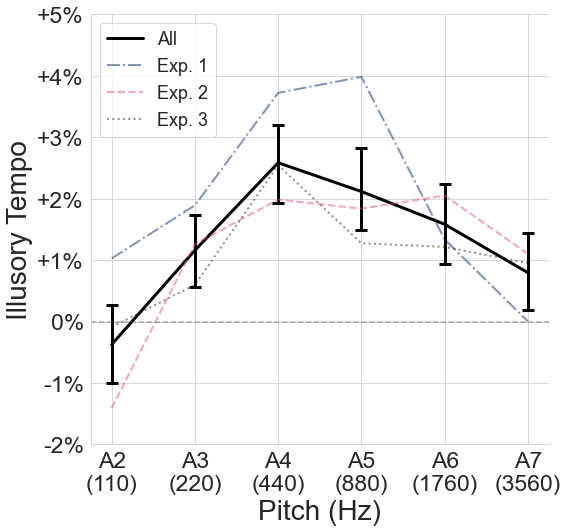

In [7]:
plt.figure()
sns.lineplot(x='pitch', y='illusory_tempo', data=data, color='k', marker='',
             err_style='bars', err_kws=dict(capsize=6, lw=3, capthick=3), lw=3, label='All')
sns.lineplot(x='pitch', y='illusory_tempo', data=data[data.subject < 1000], color='#002c6a', marker='', ls='-.', err_style=None, lw=2, alpha=.5, label='Exp. 1')
sns.lineplot(x='pitch', y='illusory_tempo', data=data[(data.subject > 1000) & (data.subject < 2000)], color='#e45171', marker='', ls='--', err_style=None, lw=2, alpha=.5, label='Exp. 2')
sns.lineplot(x='pitch', y='illusory_tempo', data=data[data.subject > 2000], color='#341c02', marker='', ls=':', err_style=None, lw=2, alpha=.5, label='Exp. 3')
plt.legend(loc=2)
plt.axhline(0, ls='--', c='#5E6A71', alpha=.5)
plt.ylim(-2, 5)
plt.xticks(range(2, 8), ['A2\n(110)', 'A3\n(220)', 'A4\n(440)', 'A5\n(880)', 'A6\n(1760)', 'A7\n(3560)'])
plt.yticks(range(-2, 6), ['-2%', '-1%', '0%', '+1%', '+2%', '+3%', '+4%', '+5%'])
plt.xlabel('Pitch (Hz)')
plt.ylabel('Illusory Tempo')
plt.gcf().set_size_inches(8, 7.5)
plt.tight_layout()
#plt.gcf().savefig(FIGURE_PATH + 'illusory_pitch_combined.svg')

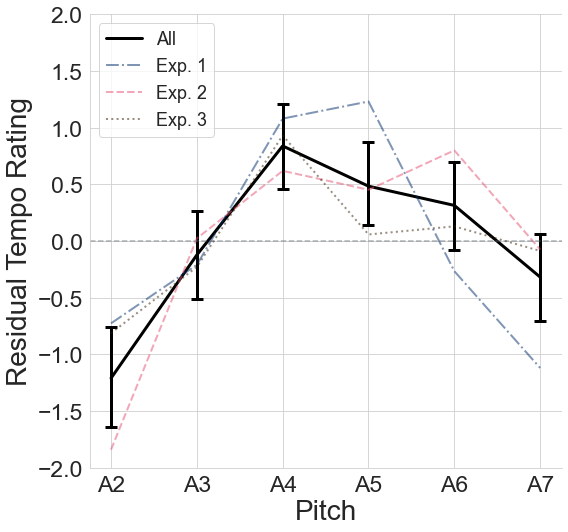

In [8]:
plt.figure()
sns.lineplot(x='pitch', y='residual', data=data, color='k', marker='',
             err_style='bars', err_kws=dict(capsize=6, lw=3, capthick=3), lw=3, label='All')
sns.lineplot(x='pitch', y='residual', data=data[data.subject < 1000], color='#002c6a', marker='', ls='-.', err_style=None, lw=2, alpha=.5, label='Exp. 1')
sns.lineplot(x='pitch', y='residual', data=data[(data.subject > 1000) & (data.subject < 2000)], color='#e45171', marker='', ls='--', err_style=None, lw=2, alpha=.5, label='Exp. 2')
sns.lineplot(x='pitch', y='residual', data=data[data.subject > 2000], color='#341c02', marker='', ls=':', err_style=None, lw=2, alpha=.5, label='Exp. 3')
plt.legend(loc=2)
plt.axhline(0, ls='--', c='#5E6A71', alpha=.5)
plt.ylim(-2, 2)
plt.xticks(range(2, 8), ['A2', 'A3', 'A4', 'A5', 'A6', 'A7'])
plt.xlabel('Pitch')
plt.ylabel('Residual Tempo Rating')
plt.gcf().set_size_inches(8, 7.5)
plt.tight_layout()
plt.gcf().savefig(FIGURE_PATH + 'pitch_combined.svg')

# Illusory Tempo by Tempo Range

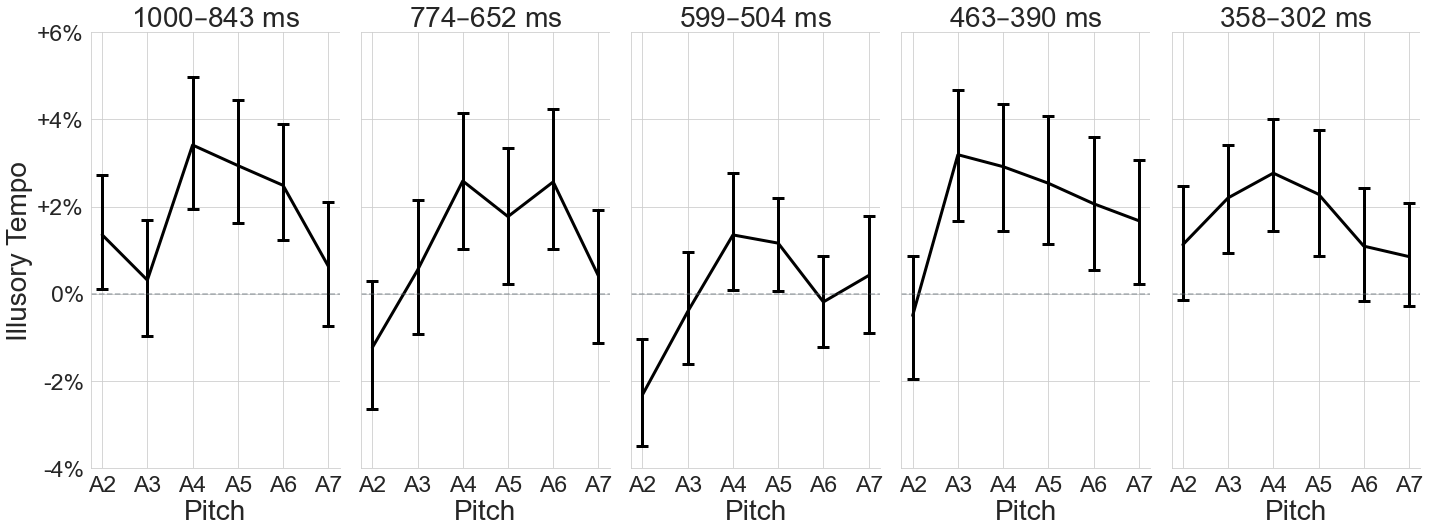

In [9]:
plt.figure()

tempo_levels = ['1000$\endash$843 ms', '774$\endash$652 ms', '599$\endash$504 ms', '463$\endash$390 ms', '358$\endash$302 ms']

for i in range(1, 6):
    plt.subplot(1, 5, i)
    sns.lineplot(x='pitch', y='illusory_tempo', data=data[data.tempo_range==i], color='k',
                 marker='', err_style='bars', err_kws=dict(capsize=6, lw=3, capthick=3), lw=3)
    plt.axhline(0, ls='--', c='#5E6A71', alpha=.5)
    plt.title(tempo_levels[i-1], fontsize=28)
    plt.ylim(-4, 6)
    if i == 1:
        plt.yticks([-4, -2, 0, 2, 4, 6], ['-4%', '-2%', '0%', '+2%', '+4%', '+6%'])
    else:
        plt.yticks([-4, -2, 0, 2, 4, 6], [])
    plt.xticks(range(2, 8), ['A2', 'A3', 'A4', 'A5', 'A6', 'A7'])
    plt.xlabel('Pitch')# if i==3 else '')
    plt.ylabel('Illusory Tempo' if i==1 else '')

plt.gcf().set_size_inches(20, 7.5)
plt.tight_layout()
#plt.gcf().savefig(FIGURE_PATH + 'illusory_pitch_combined.svg')

In [ ]:
plt.figure()
tempo_levels = ['1000$\endash$843 ms', '774$\endash$652 ms', '599$\endash$504 ms', '463$\endash$390 ms', '358$\endash$302 ms']

for i in range(1, 6):
    plt.subplot(1, 5, i)
    sns.lineplot(x='pitch', y='residual', data=data[data.tempo_range==i], color='k',
                 marker='', err_style='bars', err_kws=dict(capsize=6, lw=3, capthick=3), lw=3)
    plt.axhline(0, ls='--', c='#5E6A71', alpha=.5)
    plt.title(tempo_levels[i-1], fontsize=28)
    plt.ylim(-4, 4)
    if i > 1:
        plt.yticks([-4, -2, 0, 2, 4], [])
    plt.xticks(range(2, 8), ['A2', 'A3', 'A4', 'A5', 'A6', 'A7'])
    plt.xlabel('Pitch')# if i==3 else '')
    plt.ylabel('Residual Tempo Rating' if i==1 else '')

plt.gcf().set_size_inches(20, 6)
plt.tight_layout()
plt.gcf().savefig(FIGURE_PATH + 'pitch_by_tempo_combined.svg')

# Illusory Tempo by Tapping Condition

In [ ]:
# Print tap condition counts
print('NTI:', np.sum(data.tap_type == 0))
print('TI-NT:', np.sum(data.tap_type == 1))
print('TI-YT:', np.sum(data.tap_type == 2))

In [ ]:
plt.figure()
tap_condis = ['Non-Tapping', 'Tappping']
tap_codes = [0, 2]

for i in range(2):
    plt.subplot(1, 2, i+1)
    sns.lineplot(x='pitch', y='illusory_tempo', data=data[data.tap_type==tap_codes[i]], color='k',
                 marker='', err_style='bars', err_kws=dict(capsize=6, lw=3, capthick=3), lw=3)
    plt.axhline(0, ls='--', c='#5E6A71', alpha=.5)
    plt.title(tap_condis[i], fontsize=28)
    plt.xlabel('Pitch')
    plt.ylabel('Illusory Tempo' if i==0 else '')
    plt.xticks(range(2, 8), ['A2\n(110)', 'A3\n(220)', 'A4\n(440)', 'A5\n(880)', 'A6\n(1760)', 'A7\n(3560)'])
    plt.yticks(range(-2, 6), ['-2%', '-1%', '0%', '+1%', '+2%', '+3%', '+4%', '+5%'])
    plt.ylim(-2, 5)

plt.gcf().set_size_inches(15, 7.5)
plt.tight_layout()
#plt.gcf().savefig(FIGURE_PATH + 'pitch_tap_combined.svg')

In [ ]:
plt.figure()
tap_condis = ['NTI', 'TI-NT', 'TI-YT']

for i in range(3):
    plt.subplot(1, 3, i+1)
    sns.lineplot(x='pitch', y='residual', data=data[data.tap_type==i], color='k', 
                 marker='', err_style='bars', err_kws=dict(capsize=6, lw=3, capthick=3), lw=3)
    plt.axhline(0, ls='--', c='#5E6A71', alpha=.5)
    plt.title(tap_condis[i], fontsize=28)
    plt.xlabel('Pitch')
    plt.ylabel('Residual Tempo Rating' if i==0 else '')
    plt.xticks(range(2, 8), ['A2', 'A3', 'A4', 'A5', 'A6', 'A7'])
    plt.ylim(-3, 3)
        
plt.gcf().set_size_inches(19, 6)
plt.tight_layout()
plt.gcf().savefig(FIGURE_PATH + 'pitch_tap_combined.svg')

# Survey Analysis

Please note that in order to preserve participant privacy, survey responses have not been made open access. Please contact the authors for access to data regarding demographics and musical experience.

In [ ]:
SURVFILE1 = '../../E1/data/survey_responses.csv'
SURVFILE2 = '../../E2/data/survey_responses.csv'
SURVFILE3 = '../data/survey_responses.csv'

subj_list = data.subject.unique()
for i, survey_file in enumerate((SURVFILE1, SURVFILE2, SURVFILE3)):

    # Find participants from current experiment and revert their adjusted unique ID to their original ID
    print('EXPERIMENT %i' % (i + 1))
    exp_subj_list = subj_list[(subj_list >= i * 1000) & (subj_list < (i + 1)*1000)]
    exp_subj_list -= i * 1000

    # Load survey data and rename ID to subject
    surv = pd.read_csv(survey_file)
    surv.rename(columns={'id':'subject'}, inplace=True)

    # Select only survey responses from participants included in analyses
    surv = surv[np.in1d(surv.subject, exp_subj_list)]
    surv.reset_index()

    # Add column indicating which tapping instructions the person received
    surv['tap_condition'] = np.array([data[data.subject == s + (i * 1000)].tap_condition.iloc[0] for s in surv.subject])

    # Clean up age and gender responses
    gender_map = {
        'M': 0,
        'MALE': 0,
        'F': 1,
        'FEMALE': 1,
        'FEMALE1': 1,
        'FEMALE.': 1,
        'FEMALW': 1
    }
    surv.sex = np.array([gender_map[s.upper().strip()] for s in surv.sex], dtype=bool)
    surv.age = [int(''.join(i for i in x if i.isdigit())) for x in surv.age] if i >= 1 else surv.age

    # Print age stats
    print('Minimum Age:', surv.age.min())
    print('Maximum Age:', surv.age.max())
    print('Mean Age:', surv.age.mean())
    print('StdDev Age:', surv.age.std())

    # Print gender stats
    print('Number of Males:', np.sum(surv.sex == 0))
    print('Number of Females:', np.sum(surv.sex == 1))
    print('Number of No-Tap Females:', np.sum((surv.sex == 1) & (surv.tap_condition == 0)))
    print('Number of Tap Females:', np.sum((surv.sex == 1) & (surv.tap_condition == 1)))